# Market Making with Alpha - APT

## Overview

Continuing from [Market Making with Alpha - Basis](https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Basis.html), this example demonstrates market making based on [Arbitrage Pricing Theory](https://en.wikipedia.org/wiki/Arbitrage_pricing_theory).



<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
import datetime
import os

import numpy as np

from numba import njit, uint64
from numba.typed import Dict

from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest,
    GTX,
    LIMIT,
    BUY,
    SELL,
    BUY_EVENT,
    SELL_EVENT,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord

import polars as pl
import statsmodels.api as sm
from matplotlib import pyplot

In [2]:
start_date = datetime.datetime.strptime('20240901', '%Y%m%d')
end_date = datetime.datetime.strptime('20241031', '%Y%m%d')

In [3]:
def load_bookticker(file):
    return pl.read_csv(file, schema={
        'exchange': pl.String,
        'symbol': pl.String,
        'timestamp': pl.Int64,
        'local_timestamp': pl.Int64,
        'ask_amount': pl.Float64,
        'ask_price': pl.Float64,
        'bid_price': pl.Float64,
        'bid_amount': pl.Float64
    }).with_columns(
        pl.col('local_timestamp').cast(pl.Datetime),
        mid_price = (.5 * (pl.col('bid_price') + pl.col('ask_price'))),
    ).select(['local_timestamp', 'mid_price'])

def prepare_px_return(spot_file, futures_file, sampling_interval, rolling_window, shift):
    spot = load_bookticker(spot_file)
    futures = load_bookticker(futures_file)

    # Resamples prices to calculate returns.
    spot_rs = spot.group_by_dynamic(
        index_column='local_timestamp',
        every=sampling_interval
    ).agg(
        pl.col('mid_price').last()
    ).upsample(
        time_column='local_timestamp',
        every=sampling_interval
    ).select(pl.all().forward_fill())
    
    futures_rs = futures.group_by_dynamic(
        index_column='local_timestamp',
        every=sampling_interval
    ).agg(
        pl.col('mid_price').last(),
    ).upsample(
        time_column='local_timestamp',
        every=sampling_interval
    ).select(pl.all().forward_fill())

    # When computing returns, if one chooses the past price at a specific time point, 
    # it may result in selecting an noiser value, leading to a noisier return calculation.
    # 
    # To mitigate this issue, the average price over a past period is used. 
    # For example, to compute 5-minute returns, the average price over a 5-minute window centered around 5 minutes ago is used.
    
    return spot_rs.join(
        futures_rs,
        left_on='local_timestamp',
        right_on='local_timestamp',
        how='full'
    ).with_columns(
        futures_px=pl.col('mid_price_right').forward_fill(),
        spot_px=pl.col('mid_price').forward_fill()
    ).with_columns(
        futures_past_px=pl.col('futures_px').rolling_mean(window_size=rolling_window).shift(shift),
        spot_past_px=pl.col('spot_px').rolling_mean(window_size=rolling_window).shift(shift)
    ).with_columns(
        local_timestamp=pl.col('local_timestamp').dt.timestamp('ns'),
        spot_return=pl.col('spot_px') / pl.col('spot_past_px') - 1,
        futures_return=pl.col('futures_px') / pl.col('futures_past_px') - 1,
    ).select(
        ['local_timestamp', 'spot_return', 'spot_past_px', 'futures_return', 'futures_past_px']
    )

In [4]:
data = []
date = start_date
while date <= end_date:
    data.append(prepare_px_return(
        f'spot/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        f'usdm/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        '100ms',
        3000, # 5-minute
        1500 # 2.5-minute, the average price over a 5-minute window centered around 5 minutes ago
    ).to_numpy())
    date += datetime.timedelta(days=1)
precompute_data = np.concatenate(data, axis=0)

In [5]:
np.savez_compressed("precompute_px_return_BTCUSDT_5m", data=precompute_data)

In [6]:
precompute_data = np.load("precompute_px_return_BTCUSDT_5m.npz")["data"]

In [7]:
spot_returns = precompute_data[:, 1]
futures_returns = precompute_data[:, 3]
m = np.isfinite(spot_returns) & np.isfinite(futures_returns)

spot_returns = spot_returns[m]
futures_returns = futures_returns[m]

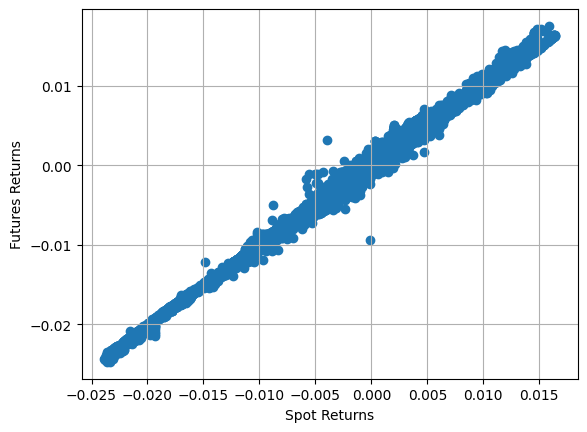

In [8]:
pyplot.scatter(spot_returns, futures_returns)
pyplot.xlabel('Spot Returns')
pyplot.ylabel('Futures Returns')
pyplot.grid()

In [9]:
X = sm.add_constant(spot_returns)

model = sm.OLS(futures_returns, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.454e+10
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        07:04:09   Log-Likelihood:             4.2591e+08
No. Observations:            52429249   AIC:                        -8.518e+08
Df Residuals:                52429247   BIC:                        -8.518e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.972e-08   9.91e-09      1.990      0.0

Under Arbitrage Pricing Theory, the relationship between futures return and spot return can be expressed as:

$Return_{futures} = \alpha + \beta_{spot} * Return_{spot}$

Under the assumption that $\beta_{spot}$ = 1 and $\alpha$ = 0, the futures return should be equal to the spot return. This also implies that any residual movement is mean-reverting to zero, similar to what is shown in the basis example.

**Extending the Model**

Beyond this basic relationship, additional return-contributing factors can be incorporated. For instance, returns from other exchanges’ Bitcoin markets, such as:

* CME Bitcoin futures, Bybit's BTC futures and other platforms's BTC futures
* Bitcoin ETFs
* Spot prices from Coinbase, Kraken, and other platforms

Moreover, this is not limited to the same asset. Other cryptocurrencies, traditional assets, and macroeconomic indices can be considered, such as:

* Ethereum (ETH)
* S&P 500
* Dollar Index

Additionally, market microstructure factors, such as order book imbalance, can further enhance the model, as demonstrated in [our other example](https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.html).

This broader framework allows for a more comprehensive understanding of price movements and their underlying drivers.

In [10]:
@njit
def apt_mm(
    hbt,
    stat,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
):
    asset_no = 0

    tick_size = hbt.depth(0).tick_size
    lot_size = hbt.depth(0).lot_size
    
    roi_lb_tick = int(round(roi_lb / tick_size))
    roi_ub_tick = int(round(roi_ub / tick_size))

    data_i = 0
    spot_return = np.nan
    futures_past_px = np.nan
    
    while hbt.elapse(interval) == 0:
        hbt.clear_inactive_orders(asset_no)
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        while data_i < len(precompute_data):
            if precompute_data[data_i, 0] > hbt.current_timestamp:
                if data_i > 0:
                    spot_return = precompute_data[data_i - 1, 1]
                    futures_past_px = precompute_data[data_i - 1, 4]
                break
            data_i += 1

        #--------------------------------------------------------
        # Computes bid price and ask price.

        mid_price = (best_bid + best_ask) / 2.0
        order_qty = max(round((order_qty_dollar / mid_price) / lot_size) * lot_size, lot_size)
        
        normalized_position = position / order_qty

        relative_bid_depth = half_spread + skew * normalized_position
        relative_ask_depth = half_spread - skew * normalized_position
        beta = 1
        alpha = 0
        return_ = beta * spot_return + alpha
        fair_px = (1 + return_) * futures_past_px

        bid_price = min(fair_px * (1.0 - relative_bid_depth), best_bid)
        ask_price = max(fair_px * (1.0 + relative_ask_depth), best_ask)
        
        bid_price = np.floor(bid_price / tick_size) * tick_size
        ask_price = np.ceil(ask_price / tick_size) * tick_size
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price < max_position_dollar and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price > -max_position_dollar and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [11]:
%%time

roi_lb = 10000
roi_ub = 90000

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime("%Y%m%d")))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20240831_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(10_000_000, 10_000_000)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 1
grid_interval = hbt.depth(0).tick_size

apt_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcusdt_return_5m.npz')

CPU times: user 1h 2min 30s, sys: 1min 50s, total: 1h 4min 20s
Wall time: 40min 16s


In [12]:
data = np.load('stats/underlying_btcusdt_return_5m.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-01 00:00:00,2024-10-31 23:55:00,6.801096,9.590116,0.047411,0.008856,518.324586,10.366475,5.35366,0.000075,1.0443e6


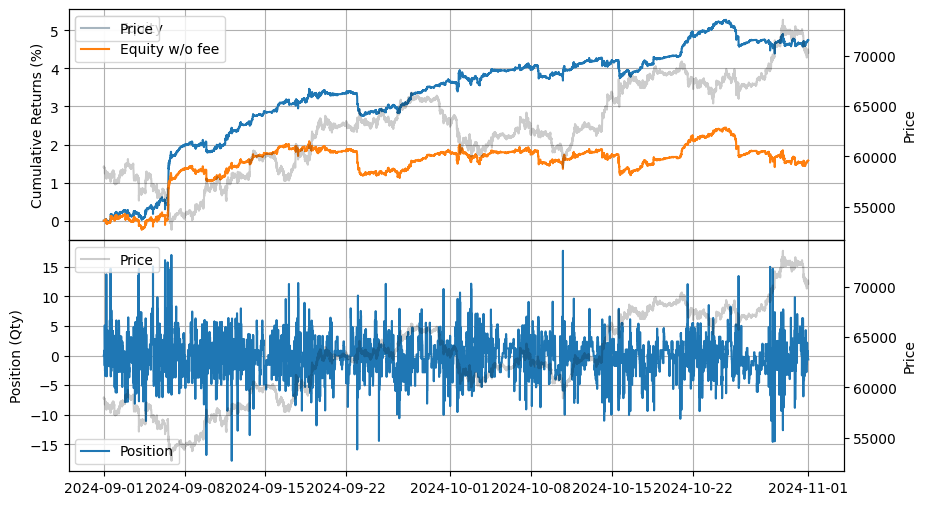

In [13]:
stats.plot()

As demonstrated in the basis example, BTCFDUSD behaves in a similar manner.

In [14]:
data = []
date = start_date
while date <= end_date:
    data.append(prepare_px_return(
        f'spot/book_ticker/BTCFDUSD/BTCFDUSD_{date.strftime("%Y%m%d")}.csv.gz',
        f'usdm/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        '100ms',
        3000, # 5-minute window
        1500 # 2.5-minute, the average price over a 5-minute window centered around 5 minutes ago
    ).to_numpy())
    date += datetime.timedelta(days=1)
precompute_data = np.concatenate(data, axis=0)

In [15]:
np.savez_compressed("precompute_px_return_BTCFDUSD_5m", data=precompute_data)

In [16]:
precompute_data = np.load("precompute_px_return_BTCFDUSD_5m.npz")["data"]

In [17]:
spot_returns = precompute_data[:, 1]
futures_returns = precompute_data[:, 3]
m = np.isfinite(spot_returns) & np.isfinite(futures_returns)

spot_returns = spot_returns[m]
futures_returns = futures_returns[m]

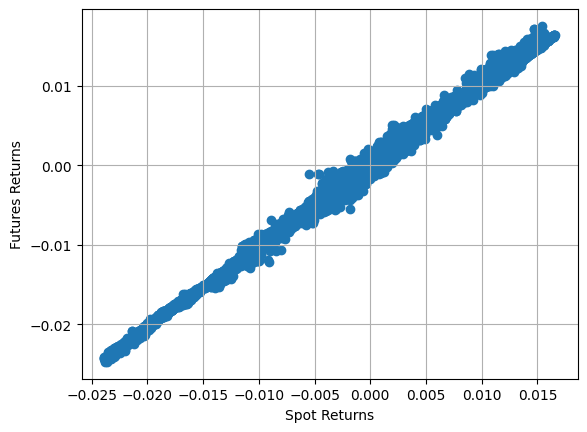

In [18]:
pyplot.scatter(spot_returns, futures_returns)
pyplot.xlabel('Spot Returns')
pyplot.ylabel('Futures Returns')
pyplot.grid()

In [19]:
X = sm.add_constant(spot_returns)

model = sm.OLS(futures_returns, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.517e+10
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        07:51:32   Log-Likelihood:             4.2702e+08
No. Observations:            52429255   AIC:                        -8.540e+08
Df Residuals:                52429253   BIC:                        -8.540e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.073e-07    9.7e-09    -11.064      0.0

In [20]:
%%time

roi_lb = 10000
roi_ub = 90000

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime("%Y%m%d")))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20240831_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(10_000_000, 10_000_000)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 1
grid_interval = hbt.depth(0).tick_size

apt_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcfdusd_return_5m.npz')

CPU times: user 1h 5min 3s, sys: 1min 56s, total: 1h 7min
Wall time: 42min 43s


In [21]:
data = np.load('stats/underlying_btcfdusd_return_5m.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-01 00:00:00,2024-10-31 23:55:00,6.061161,8.0366,0.060375,0.013698,436.467467,8.72937,4.407667,0.000113,1.0583e6


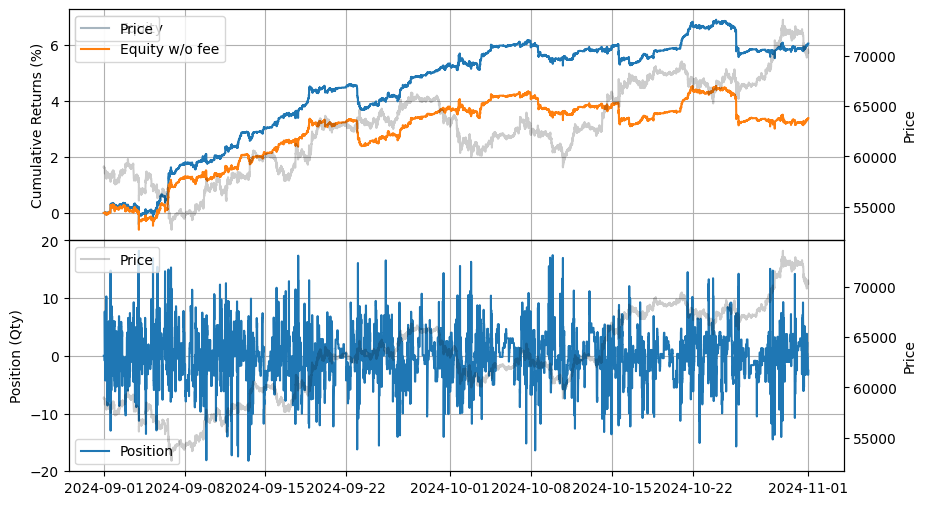

In [22]:
stats.plot()

An example using multiple linear regression based on multiple factors will be added.